In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import os
from tqdm import tqdm
import os
import json

%load_ext autoreload
%autoreload 2

In [16]:
station_name = "EEA_FR_FR04058"
station_fname = f"obs_{station_name}.csv"  # "obs_{station_name}.csv"

In [2]:
station_dir = "./all/"

In [86]:
with open("data/metadata.json") as f:
    metadata = json.loads(f.read())

In [23]:
start_date = np.datetime64("2018-01-16")  # sometimes there's data from before jan 1 2018, let's ignore that
fs = list(os.listdir(station_dir))
print("total:", len(fs))
for i, station_fname in tqdm(enumerate(fs)):
    metadata[station_fname] = dict()
    if station_fname.startswith("obs"):
        pathname = os.path.join(station_dir, station_fname)
        df = pd.read_csv(pathname, parse_dates=['ISO8601',], date_parser=lambda x: dt.datetime.strptime(x, '%Y-%m-%dT%H:%M:%SZ')).sort_values(by=['ISO8601'])
        df = df[df.ISO8601 >= start_date]
        if len(df) == 0:
            metadata[station_fname] = dict(obs=station_fname.startswith("obs"), n_data=0, quality=np.nan, lat=np.nan, lon=np.nan)
            continue
        metadata[station_fname]["obs"] = True
        metadata[station_fname]["n_data"] = sum(df.obstype=='no2')
        metadata[station_fname]["quality"] = sum(df.obstype=='no2') / ((df.ISO8601.iloc[-1] - df.ISO8601.iloc[0]).days * 24 + 23)

    if station_fname.startswith("model_forecast"):
        pathname = os.path.join(station_dir, station_fname)
        df = pd.read_csv(pathname, parse_dates=['ISO8601',], date_parser=lambda x: dt.datetime.strptime(x, '%Y-%m-%dT%H:%M:%SZ')).sort_values(by=['ISO8601'])
        df.ISO8601 -= dt.timedelta(minutes=30)  # the timestamps in mod were misaligned
        df = df[df.ISO8601 >= start_date]
        if len(df) == 0:
            metadata[station_fname] = dict(obs=station_fname.startswith("obs"), n_data=0, quality=np.nan, lat=np.nan, lon=np.nan)
            continue
        metadata[station_fname]["obs"] = False
        metadata[station_fname]["n_data"] = len(df)
        metadata[station_fname]["quality"] = len(df) / ((df.ISO8601.iloc[-1] - df.ISO8601.iloc[0]).days * 24 + 23)
        
    metadata[station_fname]["lat"] = df.iloc[0].lat
    metadata[station_fname]["lon"] = df.iloc[0].lon
    if i % 100 == 0:
        with open("data/metadata.json", "w") as f:
            f.write(json.dumps(metadata))



total: 16547


16547it [54:00,  5.11it/s]


In [36]:
with open("data/metadata.json", "w") as f:
    f.write(json.dumps(metadata))

# cluster the points

In [27]:
from sklearn.cluster import DBSCAN

In [6]:
quality_thresh = 0.5

In [89]:
coords = np.array([[s["lat"], s["lon"]] for s in metadata.values() if s["obs"] and s["quality"] > quality_thresh])
clustering = DBSCAN(eps=5, min_samples=4).fit(coords)
labs = np.unique(clustering.labels_)
labs

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18])

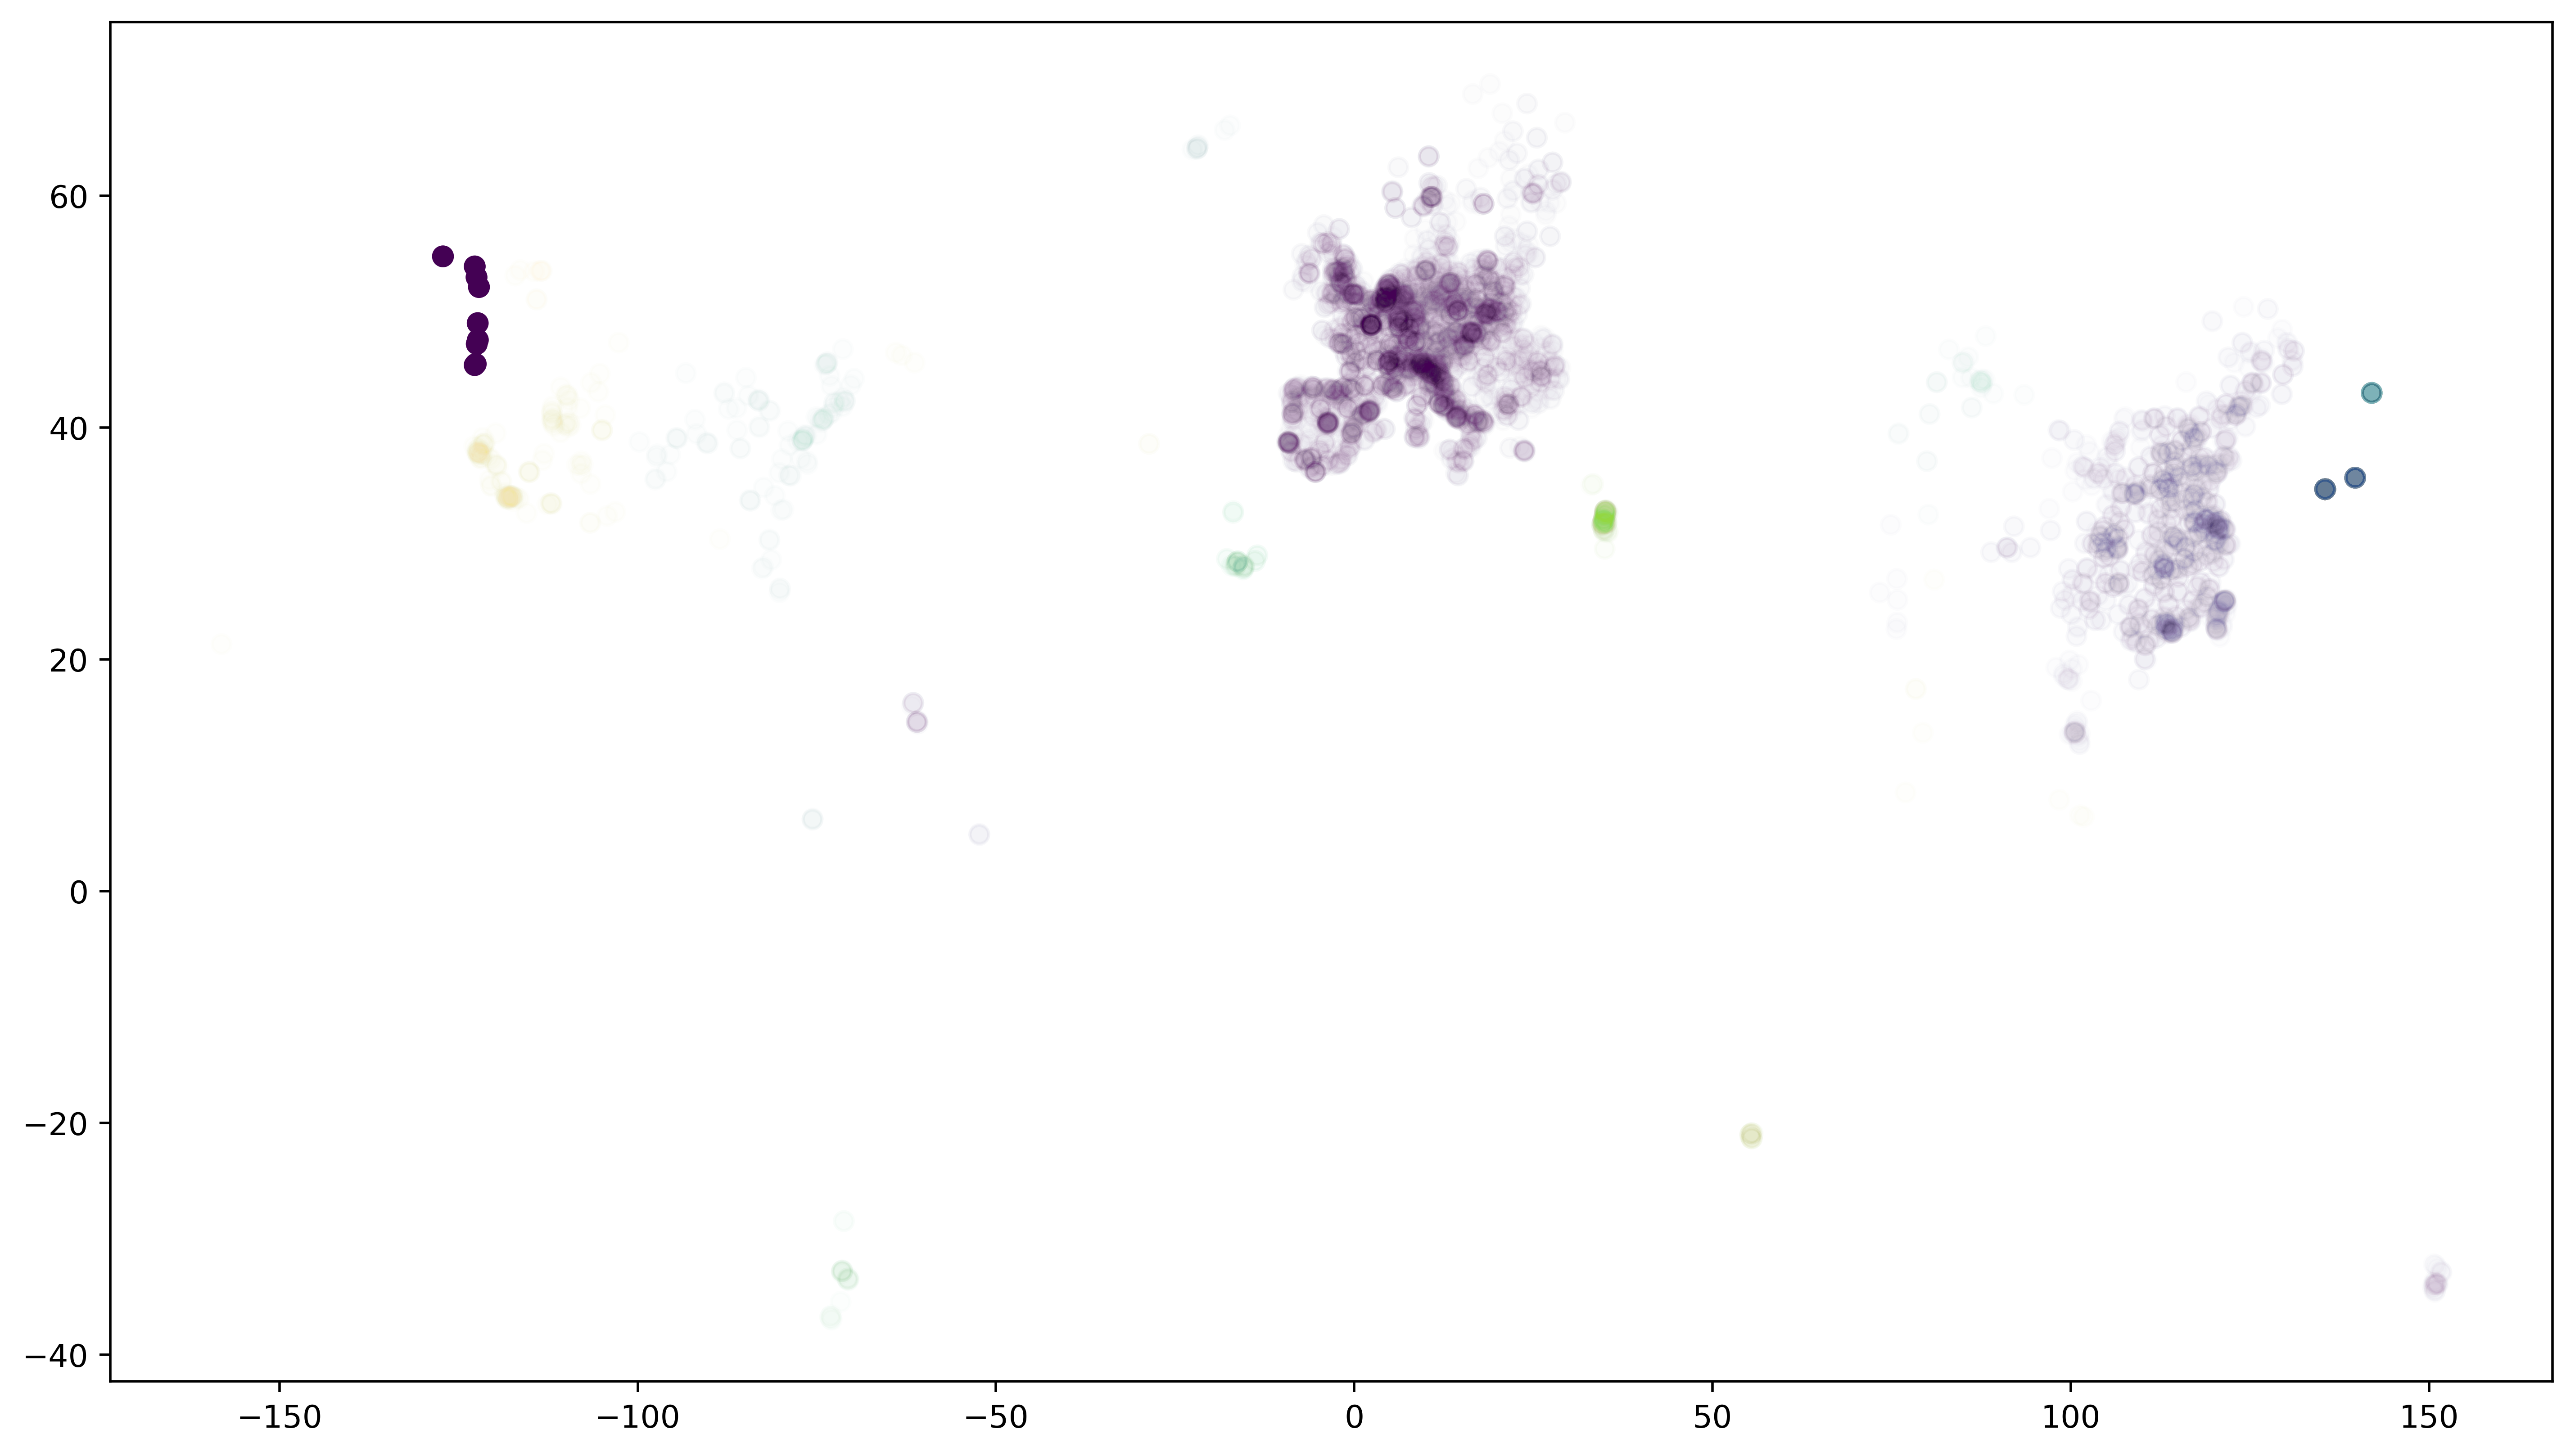

In [90]:
plt.figure(dpi=500, figsize=[14, 8])
colors = (100 * clustering.labels_) % 47
plt.scatter(coords[:, 1], coords[:, 0], c=colors, alpha=0.01)
i = 3
plt.scatter(coords[clustering.labels_ == i, 1], coords[clustering.labels_ == i, 0], c=colors[clustering.labels_ == i])
plt.show()

In [91]:
i = 0 
for station_fname in metadata:
    if metadata[station_fname]["obs"] and metadata[station_fname]["quality"] > quality_thresh:
        station_name = station_fname[4:-4]
        mod_fname = f"model_forecast_{station_name}.csv"

        metadata[mod_fname]["station"] = station_name
        metadata[station_fname]["station"] = station_name
        metadata[mod_fname]["clusters"] = [int(clustering.labels_[i])]
        metadata[station_fname]["clusters"] = [int(clustering.labels_[i])]
        i += 1


In [104]:
for station_fname in metadata:
    if "clusters" not in metadata[station_fname].keys():
        metadata[station_fname]["clusters"] = []

In [105]:
with open("data/metadata.json", "w") as f:
    f.write(json.dumps(metadata))

# Anomaly detection for a particular region

In [7]:
import random
import torch
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
from datetime import datetime
import os
import time

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
seed = 633

print("[ Using Seed : ", seed, " ]")

torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.cuda.manual_seed(seed)
numpy.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
from dpk.koopman_probabilistic import KoopmanProb
from dpk.model_objs import NormalNLL

[ Using Seed :  633  ]


In [9]:
with open("data/metadata.json") as f:
    metadata = json.loads(f.read())

cluster_id = 3
temp = []
for fname in metadata:
    temp.append(metadata[fname])
    temp[-1]["fname"] = fname
df_meta = pd.DataFrame(temp)
stations = df_meta.loc[[(cluster_id in r.clusters and r.quality > quality_thresh) for r in df_meta.iloc]].station

In [10]:
station_path = "./all/"
data_type = "obs"  # "model_forecast"

### Collect the data for the stations in this cluster, preprocess/take log, and put into multidim array

In [12]:
from scipy import interpolate

start_date = np.datetime64("2018-01-16")  # sometimes there's data from before jan 1 2018, let's ignore that
end_date = np.datetime64("2021-01-01") # exclusive
t_min = time.mktime(dt.datetime(2018, 1, 1).timetuple())
date_index = pd.date_range(dt.datetime(2018, 1, 1), dt.datetime(2021, 1, 1), freq=dt.timedelta(seconds=3600), inclusive="left")
fs = list(os.listdir(station_dir))

xt = np.full((len(date_index), len(stations)), fill_value=np.nan)  # [t, dim]
tt = np.copy(xt)
for i, station in enumerate(stations):
    station_fname = f"{data_type}_{station}.csv"
    print("quality:,", metadata[station_fname]["quality"])
    pathname = os.path.join(station_dir, station_fname)
    df = pd.read_csv(pathname, parse_dates=['ISO8601',], date_parser=lambda x: dt.datetime.strptime(x, '%Y-%m-%dT%H:%M:%SZ')).sort_values(by=['ISO8601'])
    obs = df[(df.ISO8601 >= start_date) & (df.ISO8601 < end_date) & (df.conc_obs > 0) & (df.obstype=='no2')].drop_duplicates(subset="ISO8601")
    obs["conc_obs"] = np.log(obs.conc_obs)
    obs["t"] = [time.mktime(obs.ISO8601.iloc[i].timetuple()) - t_min for i in range(len(obs))]
    obs.index = obs.ISO8601
    interp = interpolate.interp1d(obs.t.values, obs.conc_obs.values, bounds_error=False, fill_value=np.nanmean(obs.conc_obs.values))
    obs = obs.reindex(index=date_index)
    obs["t"] = [time.mktime(obs.index[i].timetuple()) - t_min for i in range(len(obs))]
    obs["conc_obs"] = interp(obs.t.values)  # todo fill with compressive sensing technique


    station_fname = f"model_forecast_{station}.csv"
    pathname = os.path.join(station_dir, station_fname)
    df = pd.read_csv(pathname, parse_dates=['ISO8601',], date_parser=lambda x: dt.datetime.strptime(x, '%Y-%m-%dT%H:%M:%SZ')).sort_values(by=['ISO8601'])
    # df.ISO8601 -= dt.timedelta(minutes=30)  # the timestamps in mod were misaligned
    mod = df[(df.ISO8601 >= start_date) & (df.ISO8601 < end_date) & (df.NO2 > 0)].drop_duplicates(subset="ISO8601")
    mod["NO2"] = np.log(mod.NO2)
    mod.index = mod.ISO8601
    mod["t"] = [time.mktime(mod.ISO8601.iloc[i].timetuple()) - t_min for i in range(len(mod))]
    interp = interpolate.interp1d(mod.t.values, mod.NO2.values, bounds_error=False, fill_value=np.nanmean(mod.NO2.values))
    mod = mod.reindex(index=date_index)
    mod["t"] = [time.mktime(mod.index[i].timetuple()) - t_min for i in range(len(mod))]
    mod["NO2"] = interp(mod.t.values)
    if data_type == "obs":
        xt[:len(obs), i] = obs.conc_obs.values
        tt[:len(obs), i] = obs.t.values
    else:
        xt[:len(mod), i] = mod.no2.values
        tt[:len(mod), i] = mod.t.values


quality:, 0.8021303484383463
quality:, 0.7220797977974364
quality:, 0.6690738400433291
quality:, 0.7464163206354938
quality:, 0.8021303484383463
quality:, 0.7220797977974364
quality:, 0.6690738400433291
quality:, 0.7464163206354938
quality:, 0.6701209604621773
quality:, 0.7637479689474634
quality:, 0.8094962989709333
quality:, 0.7918035746524643
quality:, 0.7366672684600108
quality:, 0.6701209604621773
quality:, 0.7637479689474634
quality:, 0.8094962989709333
quality:, 0.7366672684600108
quality:, 0.7918035746524643


In [13]:
(tt==tt).sum(axis=0)

array([26304, 26304, 26304, 26304, 26304, 26304, 26304, 26304, 26304,
       26304, 26304, 26304, 26304, 26304, 26304, 26304, 26304, 26304])

In [14]:
list(zip(obs.t.values, obs.ISO8601.values))

[(0.0, numpy.datetime64('NaT')),
 (3600.0, numpy.datetime64('NaT')),
 (7200.0, numpy.datetime64('NaT')),
 (10800.0, numpy.datetime64('NaT')),
 (14400.0, numpy.datetime64('NaT')),
 (18000.0, numpy.datetime64('NaT')),
 (21600.0, numpy.datetime64('NaT')),
 (25200.0, numpy.datetime64('NaT')),
 (28800.0, numpy.datetime64('NaT')),
 (32400.0, numpy.datetime64('NaT')),
 (36000.0, numpy.datetime64('NaT')),
 (39600.0, numpy.datetime64('NaT')),
 (43200.0, numpy.datetime64('NaT')),
 (46800.0, numpy.datetime64('NaT')),
 (50400.0, numpy.datetime64('NaT')),
 (54000.0, numpy.datetime64('NaT')),
 (57600.0, numpy.datetime64('NaT')),
 (61200.0, numpy.datetime64('NaT')),
 (64800.0, numpy.datetime64('NaT')),
 (68400.0, numpy.datetime64('NaT')),
 (72000.0, numpy.datetime64('NaT')),
 (75600.0, numpy.datetime64('NaT')),
 (79200.0, numpy.datetime64('NaT')),
 (82800.0, numpy.datetime64('NaT')),
 (86400.0, numpy.datetime64('NaT')),
 (90000.0, numpy.datetime64('NaT')),
 (93600.0, numpy.datetime64('NaT')),
 (97200

In [15]:
tt[:8, -1]

array([    0.,  3600.,  7200., 10800., 14400., 18000., 21600., 25200.])

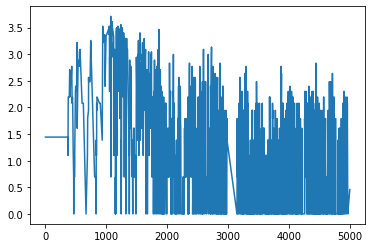

In [16]:
# TODO look at mod
plt.plot(xt[:5000, 2])

(array([ 840., 2328., 3014., 3131., 5074., 5377., 3182., 2341.,  924.,
          93.]),
 array([0.        , 0.37376696, 0.74753392, 1.12130089, 1.49506785,
        1.86883481, 2.24260177, 2.61636873, 2.99013569, 3.36390266,
        3.73766962]),
 <BarContainer object of 10 artists>)

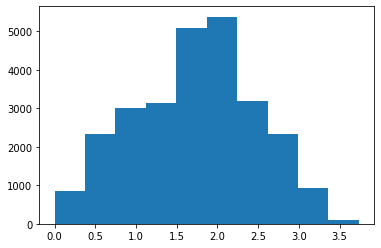

In [21]:
plt.hist(xt[:, 1]) # YES TAKE THE LOG, but throw away 0s first because they skew the distr and are probably fake

x (34704, 1)
t (34704,)
[]
x (34704, 1)
t (34704,)


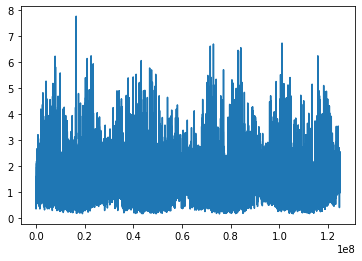

In [ ]:
# set up the time-series for prediction
chemical = "NO2"
if station_fname.startswith("obs"):
    x = np.expand_dims(obs_no2.conc_obs.values, -1)
    t = obs_no2.t.values
else:
    x = np.expand_dims(mod.no2.values, -1)
    t = mod.t.values
print("x", x.shape)
print("t", t.shape)
null_idx = np.isnan(x).nonzero()[0]
print(null_idx)
x[null_idx] = (x[null_idx - 1] + x[null_idx + 1]) / 2
if x.min() <= 0:
    print("nonpositive observed concentration: ", x[x<=0])
    x[x <= 0] = 1e-20
x_original = x
scale = np.std(x, axis=0)
x = x / np.tile(scale, (x.shape[0], 1))
print("x", x.shape)
print("t", t.shape)
plt.figure()
plt.plot(t, x)

x (20424, 1)
x_train (17544, 1)


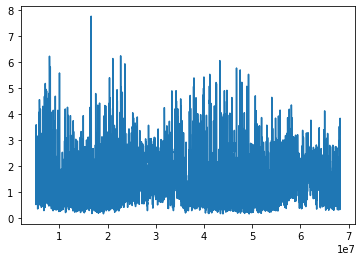

In [ ]:
# split time-series
train_start_date = np.datetime64("2018-03-16")
train_end_date = np.datetime64("2020-03-16")  # covid start date
covid_end_date = np.datetime64("2020-05-16")
if station_fname.startswith("obs"):
    train_start = np.argwhere(obs_no2.ISO8601.values >= train_start_date)[0, 0]
    train_end = np.argwhere(obs_no2.ISO8601.values <= train_end_date)[-1, 0]
    covid_end = np.argwhere(obs_no2.ISO8601.values <= covid_end_date)[-1, 0]
else:
    train_start = np.argwhere(mod.ISO8601.values >= train_start_date)[0, 0]
    train_end = np.argwhere(mod.ISO8601.values <= train_end_date)[-1, 0]
    covid_end = np.argwhere(mod.ISO8601.values <= covid_end_date)[-1, 0]
data_name = chemical + station_name

x = x[:covid_end]
t = t[:covid_end]

delay = 0

x_train = x[train_start:train_end]
t_train = t[train_start:train_end]

now = ("_".join(str(datetime.now()).split())).replace(":", ".")
print("x", x.shape)
print("x_train", x_train.shape)
plt.figure()
plt.plot(t_train, x_train)
plt.show()

In [ ]:
train_start, train_end, covid_end

(1416, 18960, 20424)

In [ ]:
# model hyperparameters
periods = 60 * 60 * np.array([24, 24 * 7, 24 * 365.24], dtype=np.float64)  # seconds
l1width = 256
l2width = 1024
wd = 1e-3
lrt = 1e-4
batch_size = 32
model = NormalNLL(x_dim=1, num_freqs=3, n=l1width, n2=l2width, num_covariates=1)  # The covariate is time

# load a pre-trained DPK model
total_iters = 100  # this indicates how long the pre-trained DPK model was trained
param_str = f"NormalNLL_{station_fname[:-4]}_{l1width}_{l2width}_{batch_size}_{total_iters}_{seed}_{wd}_{lrt}"  # you must still run 1 iteration of training on this model just to initialize the koop
# param_str = f"NormalNLL_default_{l1width}_{l2width}"  # use this pre-trained model to initialize a new model to be trained
model.load_state_dict(torch.load(f"forecasts/model_{param_str}.pt"))

koop = KoopmanProb(model, batch_size=batch_size, device="cpu")  # this koop object does the training and prediction for you
koop.init_periods(periods)
total_iters = 0

In [ ]:
iters = 1  # you must run at least 1 iteration in order for the time covariate to be scaled correctly
total_iters += iters
koop.fit(x_train, t_train, covariates=t_train.reshape(len(t_train), 1), iterations=iters, cutoff=0, weight_decay=wd, lr_theta=lrt, lr_omega=0, verbose=True)

Iteration  0
tensor([   86400.0000,   604800.0625, 31556736.0000,    86400.0000,
          604800.0625, 31556736.0000])
Setting periods to tensor([   86400.0000,   604800.0625, 31556736.0000,    86400.0000,
          604800.0625, 31556736.0000], grad_fn=<MulBackward0>)
Loss:  0.14550678
Final loss: 0.14550678


[0.14550678]

In [ ]:
# predict the mean and standard deviation
params = koop.predict(t, covariates=t.reshape(len(t), 1))
mu_hat, sigma_hat = params
mean_hat = model.mean(params)
std_hat = model.std(params)